In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns
from tqdm.notebook import tqdm
import os
sns.set()
import functools
import pickle
import itertools
import sys

In [19]:
experiments = list(itertools.product(*[
    ['sgd', 'mom'], # update algorithms
    [False, True], # mirroring
    [[32 * 32 * 3, 1024, 10], [32 * 32 * 3, 1024, 512, 512, 10]], # network [[32 * 32 * 3, 1024, 10], [32 * 32 * 3, 1024, 512, 512, 10]]layers
    run_num]))# run number

In [21]:
exp_parameters = experiments[sys.argv[1]]
update_algorithm, mirroring, network_layers, run_num = exp_parameters

In [ ]:
exp_dir = 

In [23]:
batch_size = 64

transforms = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                # torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                torchvision.transforms.Lambda(lambda x: x.flatten())])


train_dataset = torchvision.datasets.CIFAR10('./cifar10/', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.CIFAR10('./cifar10/', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [24]:
colors = list(mcolors.TABLEAU_COLORS)

def setup_axis(ax, num_epochs, title, data_shape, weights=False):
    ax.set_xlim(0, num_epochs - 1)
    ax.set_title(title)
    
    if weights:
        d = np.empty(data_shape)
        d[:] = np.nan
        data = {}
        for s in ['mean', 'std', 'max', 'min']:
            data[s] = d.copy()
        plot = []
        legend_elements = []
        for i in range(data_shape[1]):
            label = f'Layer {i}'
            mean_line = ax.plot(data['mean'][:,i], label=label, c=colors[i])[0]
            max_line = ax.plot(data['max'][:,i], c=colors[i], dashes=[6,2])[0]
            min_line = ax.plot(data['min'][:,i], c=colors[i], dashes=[6,2])[0]
            plot.append((mean_line, max_line, min_line))
            legend_elements.append(Patch(facecolor=colors[i], label=label))

        ax.legend(handles=legend_elements, loc='upper right')
        
    else:
        data = np.empty(data_shape)
        data[:] = np.nan
        plot = ax.plot(data)
    
    return data, plot

def log_data(data, new_data, epoch, simple_avg=False):
    data['mean'][epoch] = [torch.mean(layer).cpu() for layer in new_data]
    data['std'][epoch] = [torch.std(layer).cpu() for layer in new_data]
    data['max'][epoch] = [torch.max(layer).cpu() for layer in new_data]
    data['min'][epoch] = [torch.min(layer).cpu() for layer in new_data]

def set_axis_data(ax, p, data, data_std, num_epochs, simple_avg=False):
        ax.collections.clear()
        
        if type(data) == dict:
            for i, line_set in enumerate(p):
                if not simple_avg:
                    for j, name in enumerate(['mean', 'max', 'min']):
                        line_set[j].set_ydata(data[name][:,i])
                    ax.fill_between(range(num_epochs), data['mean'][:,i] - data['std'][:,i], data['mean'][:,i] + data['std'][:,i], color=colors[i], alpha=0.2)
                else:
                    line_set[0].set_ydata(data['mean'][:,i])
        else:
            p[0].set_ydata(data)
            ax.fill_between(range(num_epochs), data - (data_std * 3), data + (data_std * 3), alpha=0.2)
            
        ax.relim()
        ax.autoscale()
        ax.set_xlim(0, num_epochs - 1)

In [25]:
net_stats = {'weights': weights, 'activations': activations}

NameError: name 'weights' is not defined

In [43]:
with open('net_stats.pkl', 'wb') as f:
    pickle.dump(net_stats, f)

In [6]:
def train(net, train_loader, num_epochs, test_loader=None, num_mirrors=32):
    
    torch.manual_seed(0)
    
    criterion = nn.CrossEntropyLoss()
    
    plt.close('all')
    fig, axes = plt.subplots(1, 5, figsize=(20, 3))
    hfig = display(fig, display_id=True)
    
    weights, weights_plot = setup_axis(axes[0], num_epochs, "Weights", (num_epochs, len(net.weights)), True)
    b_weights, b_weights_plot = setup_axis(axes[1], num_epochs, "B Matrix", (num_epochs, len(net.B_weights)), True)
    activations, activations_plot = setup_axis(axes[2], num_epochs, "Activations", (num_epochs, len(net.activations)), True)
    deltas, deltas_plot = setup_axis(axes[3], num_epochs, "Matrix Deltas", (num_epochs, len(net.weights)), True)
    accuracies, accuracies_plot = setup_axis(axes[4], num_epochs, "Accuracy", (num_epochs))
    accuracies_stds = accuracies.copy()
    
    with torch.no_grad():

        net.mirror(2)
        for epoch in tqdm(range(num_epochs), desc="Epoch"):

            with tqdm(total=len(train_loader) + len(test_loader), leave=False, desc="Batch") as pbar:
                running_loss = 0
                
                batch_deltas = torch.zeros((len(net.layers), len(train_loader)))

                for batch_idx, (data, targets) in enumerate(train_loader):

                    if torch.cuda.is_available():
                        data = data.cuda()
                        targets = targets.cuda()
                        
                    y = net(data, True, True)

                    one_hot = nn.functional.one_hot(targets, num_classes=10)

                    net.update(data, y - one_hot)
                    batch_deltas[:, batch_idx] = net.mirror(1)

                    running_loss += criterion(y, targets) / data.shape[0]
                    pbar.update(1)
                    
                net.decay(epoch)

                log_data(weights, net.weights, epoch)
                log_data(b_weights, net.B_weights, epoch)
                log_data(activations, net.get_activations(), epoch)
                log_data(deltas, batch_deltas, epoch)

                test_means = np.zeros(len(test_loader))

                for batch_idx, (data, targets) in enumerate(test_loader):

                    if torch.cuda.is_available():
                        data = data.to('cuda')
                        targets = targets.to('cuda')

                    test_means[batch_idx] = torch.mean((targets == torch.argmax(net(data), axis=1)).float()).cpu()
                    pbar.update(1)

                accuracies[epoch] = np.mean(test_means)
                accuracies_stds[epoch] = np.std(test_means)

                set_axis_data(axes[0], weights_plot, weights, None, num_epochs)
                set_axis_data(axes[1], b_weights_plot, b_weights, None, num_epochs)
                set_axis_data(axes[2], activations_plot, activations, None, num_epochs)
                set_axis_data(axes[3], deltas_plot, deltas, None, num_epochs, simple_avg=True)
                set_axis_data(axes[4], accuracies_plot, accuracies, accuracies_stds, num_epochs)

                fig.canvas.draw()
                hfig.update(fig)
                
                
def angle_between(A, B):
    flat_A = A.flatten()
    normalized_flat_A = flat_A / torch.linalg.norm(flat_A)

    flat_B = B.flatten()
    normalized_flat_B = flat_B / torch.linalg.norm(flat_B)

    angle = (180.0 / torch.pi) * torch.arccos(torch.clip(torch.dot(normalized_flat_A, normalized_flat_B), -1.0, 1.0))
    return angle

def mat_stats(name, mat):
    print(f'{name}: {torch.mean(mat[x])} {torch.std(mat[x])} {torch.max(mat[x])} {torch.min(mat[x])}')

In [7]:
def generate_layer(in_size, out_size, activation=True):
    w = nn.Linear(in_size, out_size, bias=False)
    a = nn.ReLU()
    
    w_limit = np.sqrt(6.0 / in_size)
    torch.nn.init.uniform_(w.weight, a=-w_limit, b=w_limit)
    
    if not activation:
        w.weight *= 0.05
    
    return nn.Sequential(w, a) if activation else w

def collect_activations(model, l):
    def hook(self, input, output):
        model.activations[l] = output.detach()
    return hook

def angle_between(A, B):
    flat_A = A.flatten()
    normalized_flat_A = flat_A / torch.linalg.norm(flat_A)

    flat_B = B.flatten()
    normalized_flat_B = flat_B / torch.linalg.norm(flat_B)

    return (180.0 / torch.pi) * torch.arccos(torch.clip(torch.dot(normalized_flat_A, normalized_flat_B), -1.0, 1.0))

class FCNet(nn.Module):

    @torch.no_grad()
    def __init__(self, layer_sizes, learning_rate=0.01, decay_epochs=[60], update_algo='sgd', dropout=0.9, mirroring=True, final_layer=True):
        super(FCNet, self).__init__()
        
        self.learning_rate = learning_rate
        self.decay_epochs = decay_epochs
            
        self.mirroring = mirroring
        
        self.layer_sizes = layer_sizes
        self.layers_list = [generate_layer(in_size, out_size) for in_size, out_size in zip(layer_sizes, layer_sizes[1:-1])]
        self.layers_list.append(nn.Sequential(generate_layer(layer_sizes[-2], layer_sizes[-1], activation=False), nn.Softmax(dim=1) if final_layer else nn.ReLU()))
        
        self.layers = nn.Sequential(*self.layers_list)
        
        self.weights = [layer[0].weight for layer in self.layers]
        
        self.activations = [None] * len(self.layers)
        
        for l, layer in enumerate(self.layers):
            layer.register_forward_hook(collect_activations(self, l))
            
        self.B = [generate_layer(out_size, in_size, activation=False) for in_size, out_size in reversed(list(zip(layer_sizes, layer_sizes[1:])))] #[generate_layer(layer_sizes[-1], layer_sizes[0], activation=False)]
        self.B_layers = nn.Sequential(*self.B)
        self.B_weights = [b.weight for b in self.B]
        self.noises = [0.1 * (torch.randn(batch_size, self.weights[i].shape[1]).cuda()) for i in range(len(self.layers))]
        
        self.update_algo = update_algo
        if self.update_algo == 'mom':
            self.gamma = 0.9
            self.prev_update = [torch.zeros(weight.shape).cuda() for weight in self.weights]
            
        self.dropout = dropout
        self.do_masks = [None] * len(self.layers_list)
        
        if torch.cuda.is_available():
            self.cuda()
        
    @torch.no_grad()
    def get_activations(self):
        try:
            return [activations.clone() for activations in self.activations]
        except:
            return None
        
    @torch.no_grad()        
    def forward(self, x, mask=False, new_masks=False):
        for l, layer in enumerate(self.layers_list):
            x = layer(x)
            if mask and l != len(self.layers_list) - 1:
                if new_masks:
                    dropout_mask = torch.bernoulli(torch.ones(x.shape) * self.dropout).cuda() / self.dropout
                    self.do_masks[l] = dropout_mask
                else:
                    dropout_mask = self.do_masks[l]
                x *= dropout_mask
        return x

    @torch.no_grad()
    def decay(self, epoch):
        if epoch in self.decay_epochs:
            self.learning_rate *= 0.1
    
    @torch.no_grad()
    def update(self, x, e, first_block=True, last_block=True):
        if first_block:
            hl_err = x + self.B_layers(e)
        else:
            hl_err = x

        forward_activations = self.get_activations()
        modulated_forward = self.forward(hl_err, True)
        modulated_activations = self.get_activations()
        
        for l, layer in enumerate(self.layers):
            if (l == len(self.layers) - 1) and last_block:
                dwl = -e.T @ (modulated_activations[l - 1] if l != 0 else x)
            else:
                dwl = -(forward_activations[l] - modulated_activations[l]).T @ (modulated_activations[l - 1] if l != 0 else hl_err)
            
            w_update = self.learning_rate * dwl / batch_size
            if self.update_algo == 'mom':
                self.prev_update[l] = (self.gamma * self.prev_update[l]) + w_update
                w_update = self.prev_update[l]
                
            layer[0].weight += w_update
    
    @torch.no_grad()
    def mirror(self, n_reps=1, X_shape=None, mirror_learning_rate=0.01):
        deltas = []
        for _ in range(n_reps):
            for i, (layer, b_layer) in enumerate(zip(self.layers, reversed(self.B_layers))):

                if self.mirroring:
                    noise = self.noises[i]
                    dl = noise - torch.mean(noise)
                    yl1 = torch.relu(self.layers[i][0](noise))
                    dl1 = yl1 - torch.mean(yl1)
                    b_layer.weight *= 0.5
                    b_layer.weight += 0.01 * (noise.T @ yl1)#(dl.T @ dl1)
                    
                deltas.append(angle_between(layer[0].weight.T, b_layer.weight))
        
        return torch.tensor(deltas)

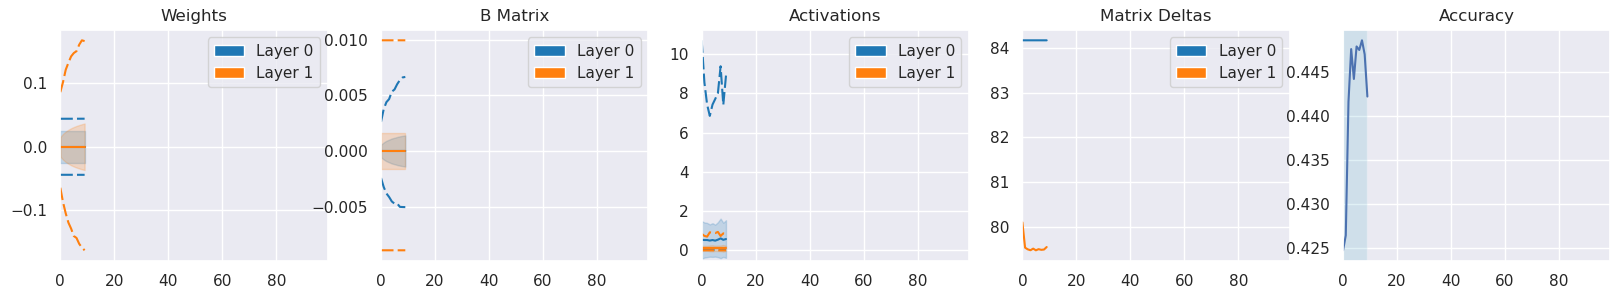

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

Batch:   0%|          | 0/939 [00:00<?, ?it/s]

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2ae4fe774a60> (for post_execute):



KeyboardInterrupt



In [8]:
# net = FCNet([32 * 32 * 3, 1024, 1024, 512, 512, 256, 256, 10], Bstd=0.05)
net = FCNet([32 * 32 * 3, 1024, 10], mirroring=True, update_algo='sgd')
d = train(net, train_loader, 100, test_loader, 2)

In [ ]:
save_dir = '/home/cpsc490_ac2788/CPSC490/figures/report4/fig3/'
os.makedirs(save_dir, exist_ok=True)
plt.savefig(save_dir + "fig.png")